In [1]:
import numpy as np
import msprime, tskit
import COPYtest_extend_edges as ee
from IPython.display import SVG

In [43]:
def total_extend(ts, max_iter, extend_first = True):
    tables = ts.dump_tables()
    mutations = tables.mutations.copy()
    tables.mutations.clear()
    done = False
    last_num_edges = ts.num_edges
    if extend_first:
        process = [ee._extend, ee._extend_paths]
    if not extend_first:
        process = [ee._extend_paths, ee._extend]
    for _ in range(max_iter):
        print('max iter', _)
        for func in process:
            for forwards in [True, False]:
                edges = func(ts, forwards = forwards)
                tables.edges.replace_with(edges)
                tables.sort()
                tables.build_index()
                ts = tables.tree_sequence()
                print(func, ts.num_edges)

        if ts.num_edges == last_num_edges:
            done = True
            break
        else:
            last_num_edges = ts.num_edges
        if done:
            break
    tables = ts.dump_tables()
    mutations = ee._slide_mutation_nodes_up(ts, mutations)
    tables.mutations.replace_with(mutations)
    tables.edges.squash()
    tables.sort()
    ts = tables.tree_sequence()

    return ts     

#### Check convergence between EE -> EP .vs. EP -> EE

In [78]:
ts = msprime.sim_ancestry(samples, population_size = 1000, sequence_length = 1e6, record_full_arg = True, random_seed = 73,
                             recombination_rate = 1e-8)
sts = ts.simplify()

In [52]:
samples = 50
ts = msprime.sim_ancestry(samples, population_size = 1000, sequence_length = 1e6, record_full_arg = True, random_seed = 73,
                             recombination_rate = 1e-8)
sts = ts.simplify()
old_num_edges = 0
k = 0
# print('simplified num edges', sts.num_edges)
# while k < 10 and sts.num_edges != old_num_edges:
#     old_num_edges = sts.num_edges
#     ext = ee.extend_edges(sts, 100)
#     print('extend edges', ext.num_edges)
#     eext = ee.extend_paths(ext)
#     print('extend paths', eext.num_edges)
#     sts = eext
#     k += 1

simplified num edges 857
extend edges 585
extend paths 616
extend edges 561
extend paths 570
extend edges 552
extend paths 552
extend edges 552
extend paths 552


In [75]:
sts = ts.simplify()
old_num_edges = 0
k = 0 
print('simplified num edges', sts.num_edges)
while k < 10 and sts.num_edges != old_num_edges:
    old_num_edges = sts.num_edges
    epts = ee.extend_paths(sts,100)
    print('extend paths', epts.num_edges)
    eets = ee.extend_edges(epts)
    print('extend edges', eets.num_edges)
    sts = eets
    k += 1

simplified num edges 857
extend paths 632
extend edges 552
extend paths 554
extend edges 550
extend paths 550
extend edges 550


In [12]:
eext.simplify().tables.assert_equals(eets.simplify().tables, ignore_provenance = True)

## Uh oh.

In [5]:
eext.tables.edges[485], eets.tables.edges[485]

(EdgeTableRow(left=698546.0, right=817047.0, parent=313, child=310, metadata=b''),
 EdgeTableRow(left=707409.0, right=817047.0, parent=313, child=310, metadata=b''))

## Attention to Edge 313 --> 310

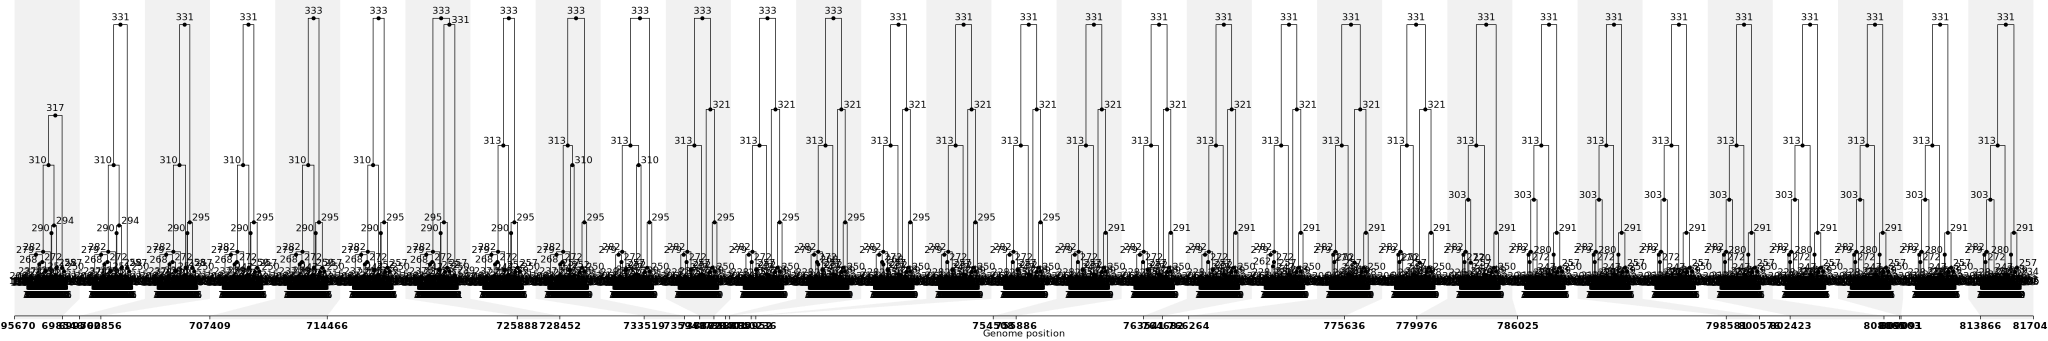

In [79]:
SVG(sts.draw_svg(x_lim = [695670,817047],size = (3000,500)))

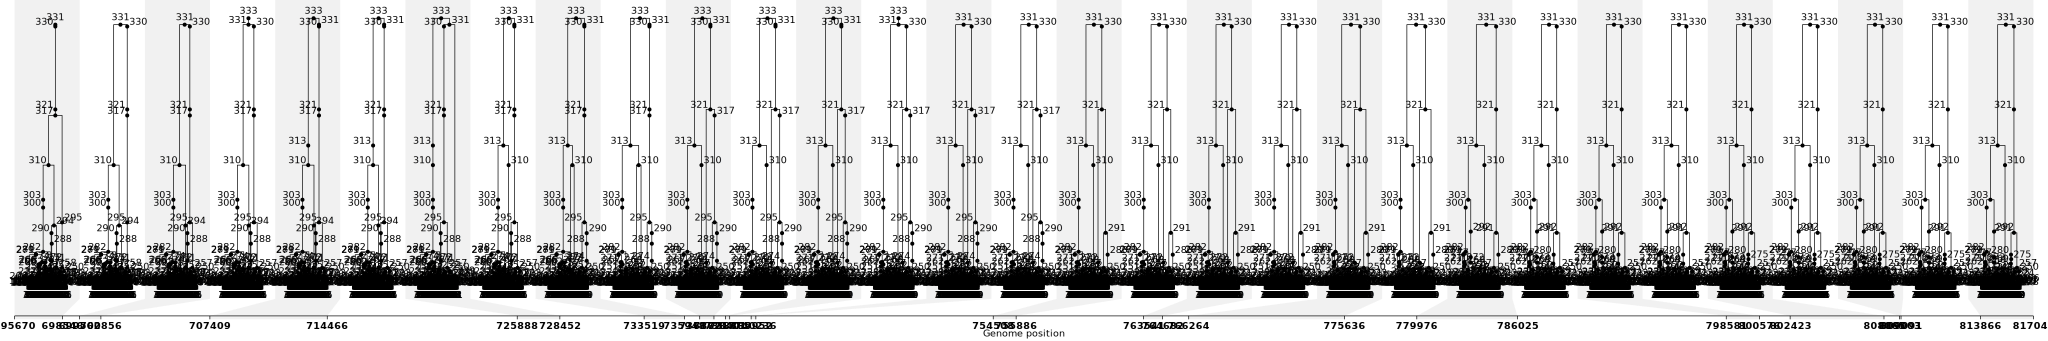

In [77]:
SVG(eets.draw_svg(x_lim = [695670,817047],size = (3000,500)))

## Notes on the difference between these Tree Sequences
`eets.num_edges = 550` This was made with $EP \to EE$.
`eext.num_edges = 552` This was made with $EE \to EP$.

EEXT extended the edge $ 313 \to 310 $ further to the left (left = 698546) than EETS (left = 707409).

For both tree sequences the only way this edge could be further extended is if we extend via `extend_paths`. EETS does not extend the edge $ 313 \to 310 $ further and I believe this is because the `outparent[313]` is a root. We try and not involve roots in the extension because it is complicated, however we may want to try and do so to improve the algorithm and make it symmetric (ie. $ EE \to EP \cong EP \to EE$).


#### Current `merge_edge_paths` for problem edge $ 313 \to 310 $ on $EETS$.

`forwards = False`, Assume `path_check = False` for all current nodes involved in construction.
$ 333 \to 310 $ in `edges_in`.

`c = 310`

`p_in = 331`

`p_out = 313`

`ipp = [310, 331]`

`opp = [310, 313, 333]`

Note that that `ipp` $\cap$ `opp` = `[310]` and so no path is extended. However if we continued to construct `ipp` a bit further we would have `ipp = [310, 331, 333]` which would contruct the path. However, this violates our "no paths through branch points rule" as it could break the algorithm and add potentially incorrect nodes in parts of the tree sequence.

## Try Total Extend (YOLO below doesn't work).

In [44]:
ts = msprime.sim_ancestry(samples, population_size = 1000, sequence_length = 1e6, record_full_arg = True, random_seed = 73,
                             recombination_rate = 1e-8)
sts = ts.simplify()
te = total_extend(sts, 100, extend_first = True)

max iter 0
<function _extend at 0x7f7b36583160> 685
<function _extend at 0x7f7b36583160> 585
<function _extend_paths at 0x7f7b36583280> 586
<function _extend_paths at 0x7f7b36583280> 616
max iter 1
<function _extend at 0x7f7b36583160> 590
<function _extend at 0x7f7b36583160> 562
<function _extend_paths at 0x7f7b36583280> 563
<function _extend_paths at 0x7f7b36583280> 576
max iter 2
<function _extend at 0x7f7b36583160> 565
<function _extend at 0x7f7b36583160> 552
<function _extend_paths at 0x7f7b36583280> 552
<function _extend_paths at 0x7f7b36583280> 552
max iter 3
<function _extend at 0x7f7b36583160> 552
<function _extend at 0x7f7b36583160> 552
<function _extend_paths at 0x7f7b36583280> 552
<function _extend_paths at 0x7f7b36583280> 552


In [45]:
ts = msprime.sim_ancestry(samples, population_size = 1000, sequence_length = 1e6, record_full_arg = True, random_seed = 73,
                             recombination_rate = 1e-8)
sts = ts.simplify()
tep = total_extend(sts, 100, extend_first = False)

max iter 0
<function _extend_paths at 0x7f7b36583280> 847
<function _extend_paths at 0x7f7b36583280> 839
<function _extend at 0x7f7b36583160> 677
<function _extend at 0x7f7b36583160> 584
max iter 1
<function _extend_paths at 0x7f7b36583280> 608
<function _extend_paths at 0x7f7b36583280> 619
<function _extend at 0x7f7b36583160> 587
<function _extend at 0x7f7b36583160> 557
max iter 2
<function _extend_paths at 0x7f7b36583280> 563
<function _extend_paths at 0x7f7b36583280> 566
<function _extend at 0x7f7b36583160> 558
<function _extend at 0x7f7b36583160> 551
max iter 3
<function _extend_paths at 0x7f7b36583280> 553
<function _extend_paths at 0x7f7b36583280> 553
<function _extend at 0x7f7b36583160> 552
<function _extend at 0x7f7b36583160> 550
max iter 4
<function _extend_paths at 0x7f7b36583280> 550
<function _extend_paths at 0x7f7b36583280> 550
<function _extend at 0x7f7b36583160> 550
<function _extend at 0x7f7b36583160> 550


In [46]:
tep.tables.assert_equals(eets.tables, ignore_provenance = True)

AssertionError: EdgeTable row 485 differs:
self.left=698546.0 other.left=707409.0

In [47]:
tep.tables.assert_equals(eext.tables, ignore_provenance = True)

AssertionError: EdgeTable row 527 differs:
self.right=817047.0 other.right=736862.0

In [48]:
te.tables.assert_equals(eext.tables, ignore_provenance = True)

### Check that EE and EP perform same choice of extension when dealing with difficult case.

In [86]:
def get_example():
    node_times = {
        0: 0,
        1: 0,
        2: 1,
        3: 2
    }
    # (p, c, l, r)
    edges = [
    (2, 0, 0, 1),
    (2, 0, 2, 3),
    (2, 1, 0, 1),
    (2, 1, 2, 3),
    (3, 0, 1, 2),
    (3, 2, 0, 1),
    (3, 2, 2, 3)
    ]
    samples = list(np.arange(2))
    tables = tskit.TableCollection(sequence_length=3)
    for (n,t,) in node_times.items():
        flags = tskit.NODE_IS_SAMPLE if n in samples else 0
        tables.nodes.add_row(time=t, flags=flags)
    for p, c, l, r in edges:
        tables.edges.add_row(parent=p, child=c, left=l, right=r)
    ts = tables.tree_sequence()
        
    return ts

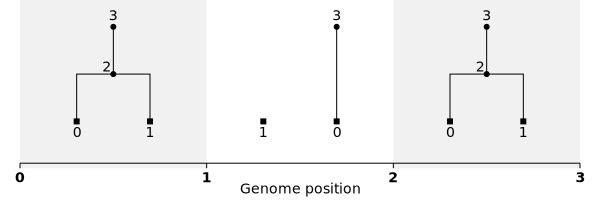

In [87]:
e = get_example()
SVG(e.draw_svg())

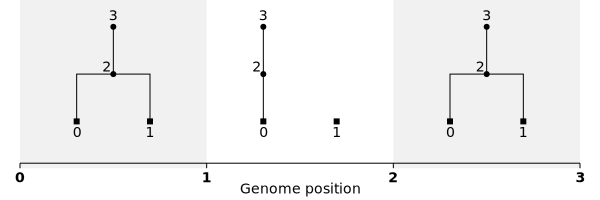

In [88]:
E = e.extend_edges()
SVG(E.draw_svg())

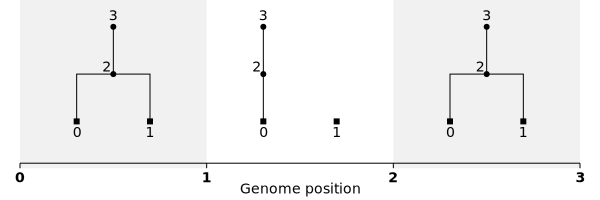

In [89]:
P = ee.extend_paths(e)
SVG(P.draw_svg())

In [98]:
def get():
        # 15.00|         |   13    |         |
        #      |         |    |    |         |
        # 12.00|   10    |   10    |    10   |
        #      |  +-+-+  |  +-+-+  |   +-+-+ |
        # 10.00|  8   |  |  |   |  |   8   | |
        #      |  |   |  |  |   |  |  ++-+ | |
        # 8.00 |  |   |  | 11  12  |  |  | | |
        #      |  |   |  |  |   |  |  |  | | |
        # 6.00 |  |   |  |  7   |  |  |  | | |
        #      |  |   |  |  |   |  |  |  | | |
        # 4.00 |  6   9  |  |   |  |  |  | | |
        #      |  |   |  |  |   |  |  |  | | |
        # 1.00 |  4   5  |  4   5  |  4  | 5 |
        #      | +++ +++ | +++ +++ | +++ | | |
        # 0.00 | 0 1 2 3 | 0 1 2 3 | 0 1 2 3 |
        #      0         3         6         9
        node_times = {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
            4: 1,
            5: 1,
            6: 4,
            7: 6,
            8: 10,
            9: 4,
            10: 12,
            11: 8,
            12: 8,
            13: 15
        }
        # (p,c,l,r)
        edges = [
            (4,0,0,9),
            (4,1,0,9),
            (5,2,0,6),
            (5,3,0,9),
            (6,4,0,3),
            (9,5,0,3),
            (7,4,3,6),
            (11,7,3,6),
            (12,5,3,6),
            (8,2,6,9),
            (8,4,6,9),
            (8,6,0,3),
            (10,5,6,9),
            (10,8,0,3),
            (10,8,6,9),
            (10,9,0,3),
            (10,11,3,6),
            (10,12,3,6),
            (13, 10, 3, 6)
        ]
        extended_path_edges = [(4, 0, 0.0, 9.0),
                               (4, 1, 0.0, 9.0),
                               (5, 2, 0.0, 6.0),
                               (5, 3, 0.0, 9.0),
                               (6, 4, 0.0, 9.0),
                               (9, 5, 0.0, 9.0),
                               (7, 6, 0.0, 9.0),
                               (11, 7, 0.0, 9.0),
                               (12, 9, 0.0, 9.0),
                               (8, 2, 6.0, 9.0),
                               (8, 11, 0.0, 9.0),
                               (10, 8, 0.0, 9.0),
                               (10, 12, 0.0, 9.0),
                               (13, 10, 3.0, 6.0)
                              ]
        samples = list(np.arange(4))
        tables = tskit.TableCollection(sequence_length=9)
        for (n,t,) in node_times.items():
            flags = tskit.NODE_IS_SAMPLE if n in samples else 0
            tables.nodes.add_row(time=t, flags=flags)
        for p, c, l, r in edges:
            tables.edges.add_row(parent=p, child=c, left=l, right=r)
        ts = tables.tree_sequence()
        tables.edges.clear()
        for p, c, l, r in extended_path_edges:
            tables.edges.add_row(parent=p, child=c, left=l, right=r)
        ets = tables.tree_sequence()
        assert ts.num_edges == 19
        assert ets.num_edges == 14
        return ts, ets

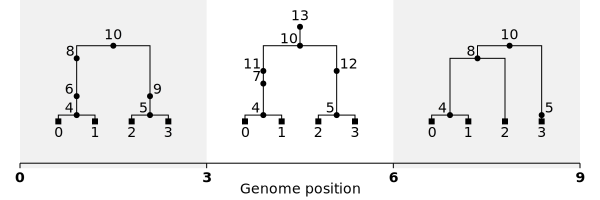

In [100]:
b,c = get()
SVG(b.draw_svg())

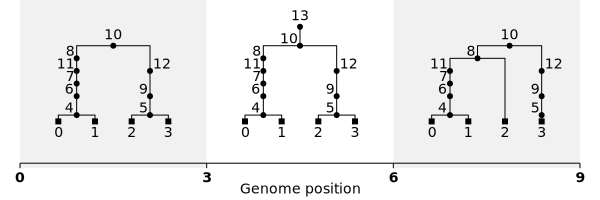

In [101]:
SVG(c.draw_svg())